In [129]:
import random
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    log_loss,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [130]:
SEED = 1

In [131]:
random.seed(SEED)
np.random.seed(SEED)

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/wojtek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wojtek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [132]:
resumes = pd.read_csv('../data/resumes.csv')
resumes.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Pre-processing

In [133]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
label_encoder = LabelEncoder()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

resumes['Resume_str'] = resumes['Resume_str'].apply(clean_text)

X = resumes['Resume_str']
y = label_encoder.fit_transform(resumes['Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

vectorizer = TfidfVectorizer(ngram_range=(1,5), stop_words=stopwords.words('english'), max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Training

In [134]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'multi:softprob',
    'num_class': len(label_encoder.classes_),
    'eval_metric': 'mlogloss',
    'learning_rate': 0.1,
}

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

class RecordMetricsCallback(xgb.callback.TrainingCallback):
    def after_iteration(self, model, epoch, evals_log):
        y_train_pred = model.predict(dtrain)
        y_test_pred = model.predict(dtest)

        train_loss = log_loss(y_train, y_train_pred)
        test_loss = log_loss(y_test, y_test_pred)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_accuracy = accuracy_score(y_train, np.argmax(y_train_pred, axis=1))
        test_accuracy = accuracy_score(y_test, np.argmax(y_test_pred, axis=1))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        return False

xgb_classifier = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    evals=[(dtest, 'test')],
    callbacks=[RecordMetricsCallback()],
)

[0]	test-mlogloss:2.60750
[1]	test-mlogloss:2.32976
[2]	test-mlogloss:2.13342
[3]	test-mlogloss:1.98263
[4]	test-mlogloss:1.86218
[5]	test-mlogloss:1.76005
[6]	test-mlogloss:1.67114
[7]	test-mlogloss:1.59840
[8]	test-mlogloss:1.53212
[9]	test-mlogloss:1.47282
[10]	test-mlogloss:1.42043
[11]	test-mlogloss:1.37100
[12]	test-mlogloss:1.32827
[13]	test-mlogloss:1.28688
[14]	test-mlogloss:1.24959
[15]	test-mlogloss:1.21434
[16]	test-mlogloss:1.18524
[17]	test-mlogloss:1.15597
[18]	test-mlogloss:1.12984
[19]	test-mlogloss:1.10639
[20]	test-mlogloss:1.08382
[21]	test-mlogloss:1.06135
[22]	test-mlogloss:1.04370
[23]	test-mlogloss:1.02452
[24]	test-mlogloss:1.00895
[25]	test-mlogloss:0.99356
[26]	test-mlogloss:0.97884
[27]	test-mlogloss:0.96511
[28]	test-mlogloss:0.95428
[29]	test-mlogloss:0.94408
[30]	test-mlogloss:0.93485
[31]	test-mlogloss:0.92564
[32]	test-mlogloss:0.91756
[33]	test-mlogloss:0.90881
[34]	test-mlogloss:0.90138
[35]	test-mlogloss:0.89403
[36]	test-mlogloss:0.88818
[37]	test-m

# Accuracy

In [135]:
y_pred_probs = xgb_classifier.predict(xgb.DMatrix(X_test))
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.7606
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        24
           1       0.72      0.82      0.77        28
           2       0.75      0.25      0.38        12
           3       0.60      0.38      0.46        16
           4       0.60      0.57      0.59        21
           5       0.44      0.50      0.47         8
           6       0.88      0.82      0.85        17
           7       0.59      0.74      0.65        23
           8       0.00      0.00      0.00         4
           9       0.88      0.72      0.79        32
          10       0.85      0.92      0.88        25
          11       0.92      0.96      0.94        23
          12       0.75      0.68      0.71        22
          13       0.89      0.85      0.87        20
          14       0.81      0.72      0.76        29
          15       0.75      0.88      0.81        24
          16       0.76      0.79      0.

/home/wojtek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wojtek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wojtek/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Loss per epoch

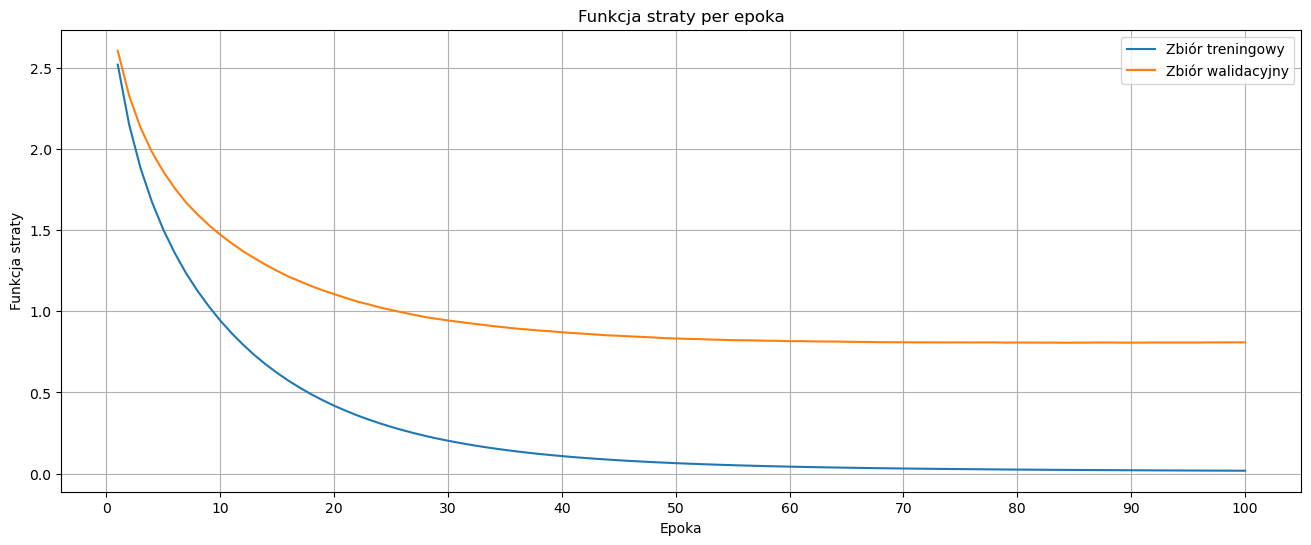

In [136]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, len(train_losses) + 1), train_losses, label='Zbiór treningowy')
plt.plot(np.arange(1, len(test_losses) + 1), test_losses, label='Zbiór walidacyjny')
plt.xticks(np.arange(0, 101, step=10))
plt.title('Funkcja straty per epoka')
plt.xlabel('Epoka')
plt.ylabel('Funkcja straty')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy per epoch

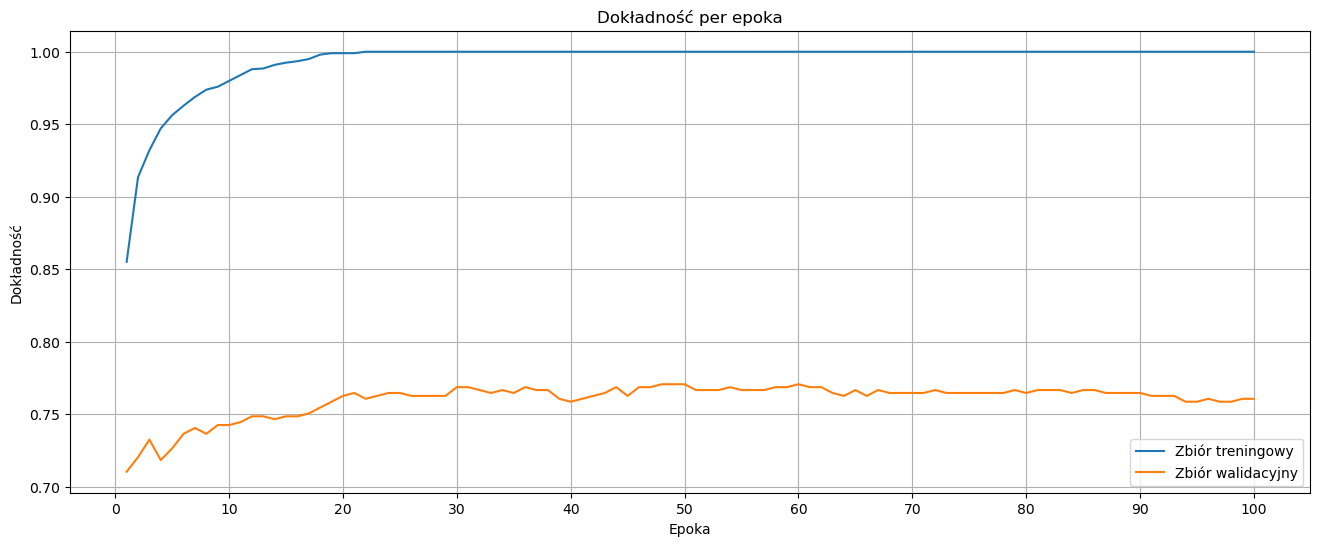

In [137]:
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, len(train_accuracies) + 1), train_accuracies, label='Zbiór treningowy')
plt.plot(np.arange(1, len(test_accuracies) + 1), test_accuracies, label='Zbiór walidacyjny')
plt.xticks(np.arange(0, 101, step=10))
plt.title('Dokładność per epoka')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix

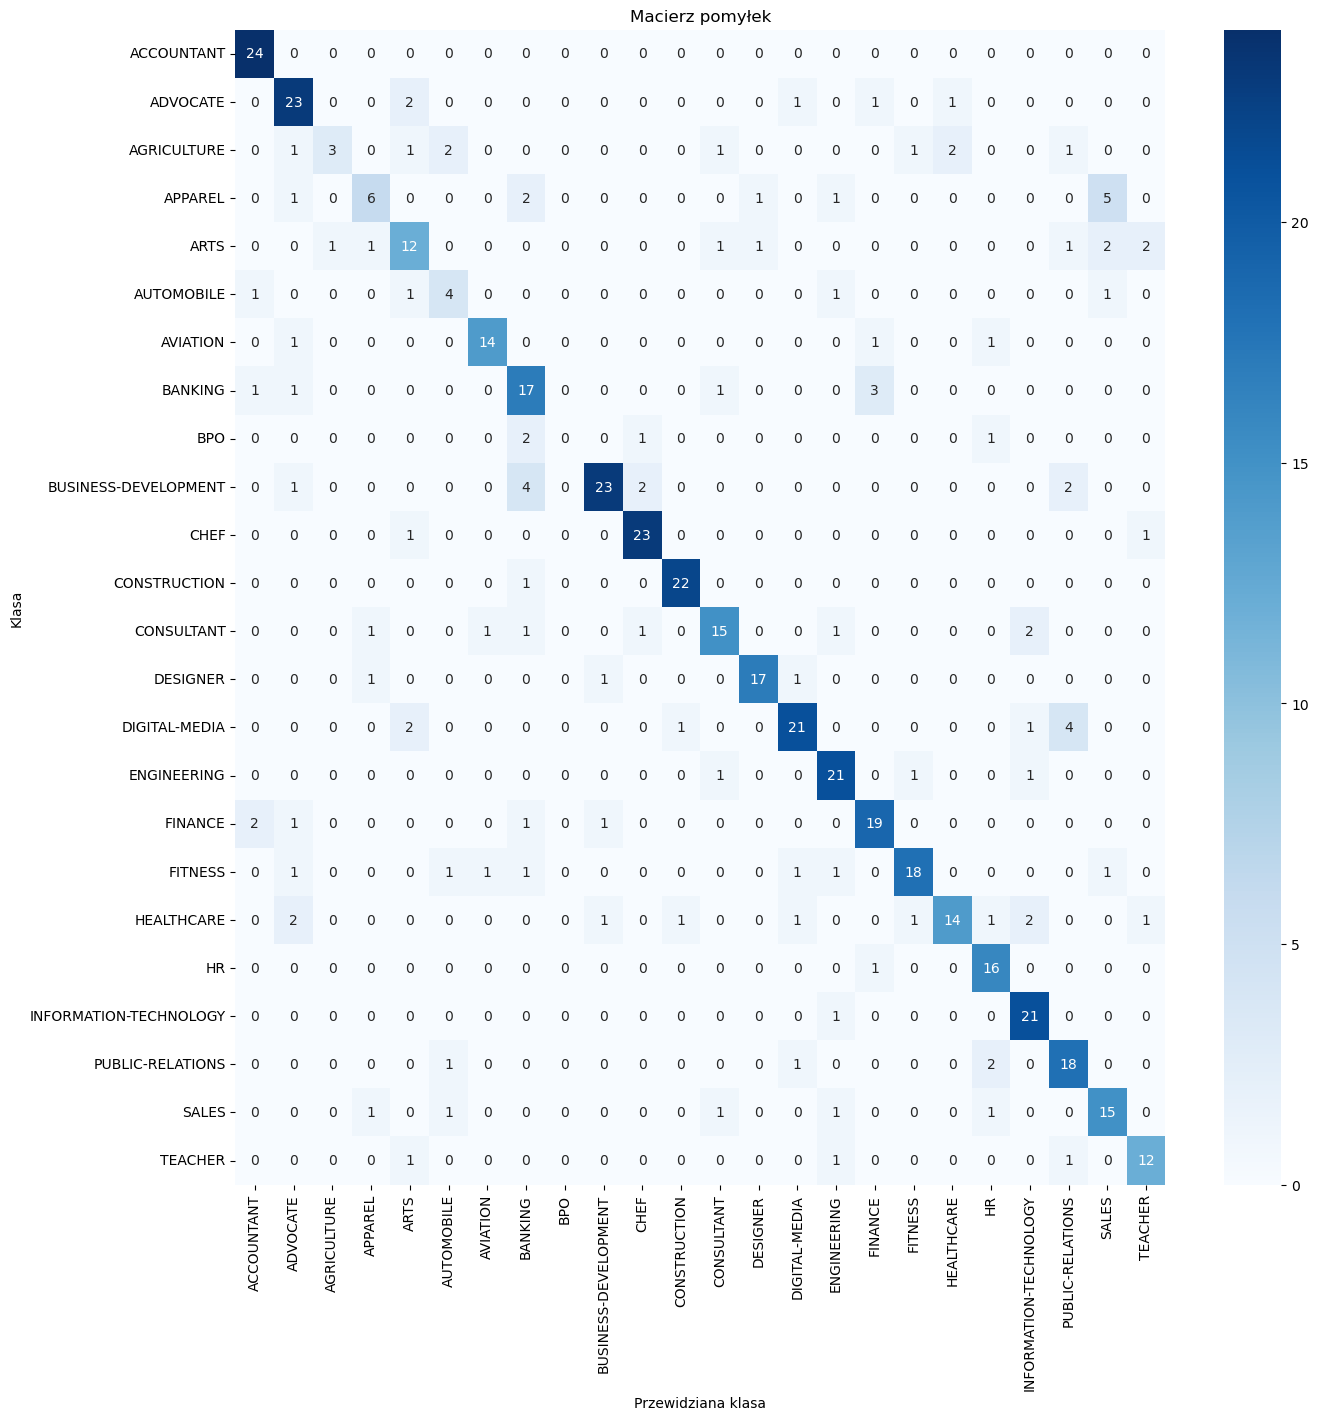

In [138]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Klasa')
plt.show()

# Accuracy per class

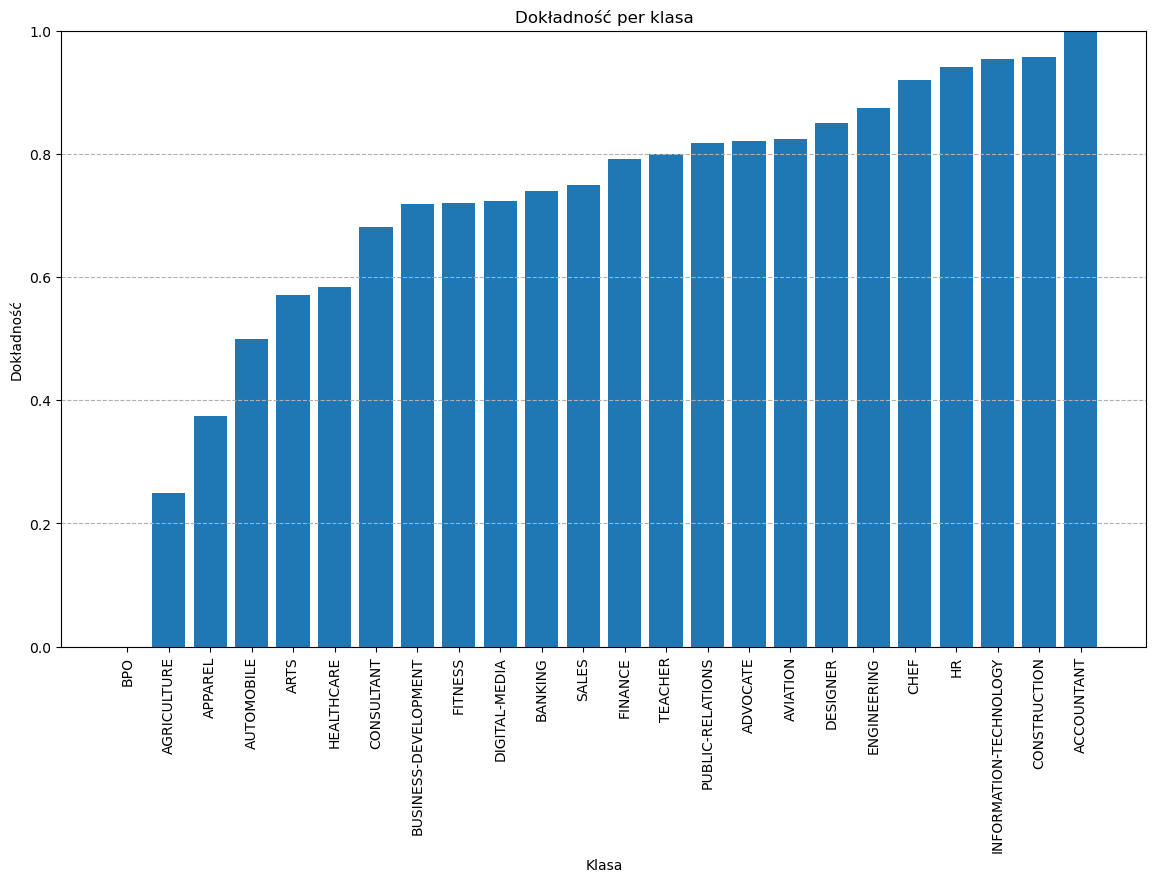

In [139]:
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

classes = label_encoder.classes_

sorted_indices = np.argsort(class_accuracies)
sorted_accuracies = class_accuracies[sorted_indices]
sorted_classes = classes[sorted_indices]

plt.figure(figsize=(14, 8))
plt.bar(sorted_classes, sorted_accuracies)
plt.xlabel('Klasa')
plt.ylabel('Dokładność')
plt.title('Dokładność per klasa')
plt.xticks(rotation=90)
plt.ylim([0, 1])
plt.grid(axis='y', linestyle='--')
plt.show()

# Gini and ROC

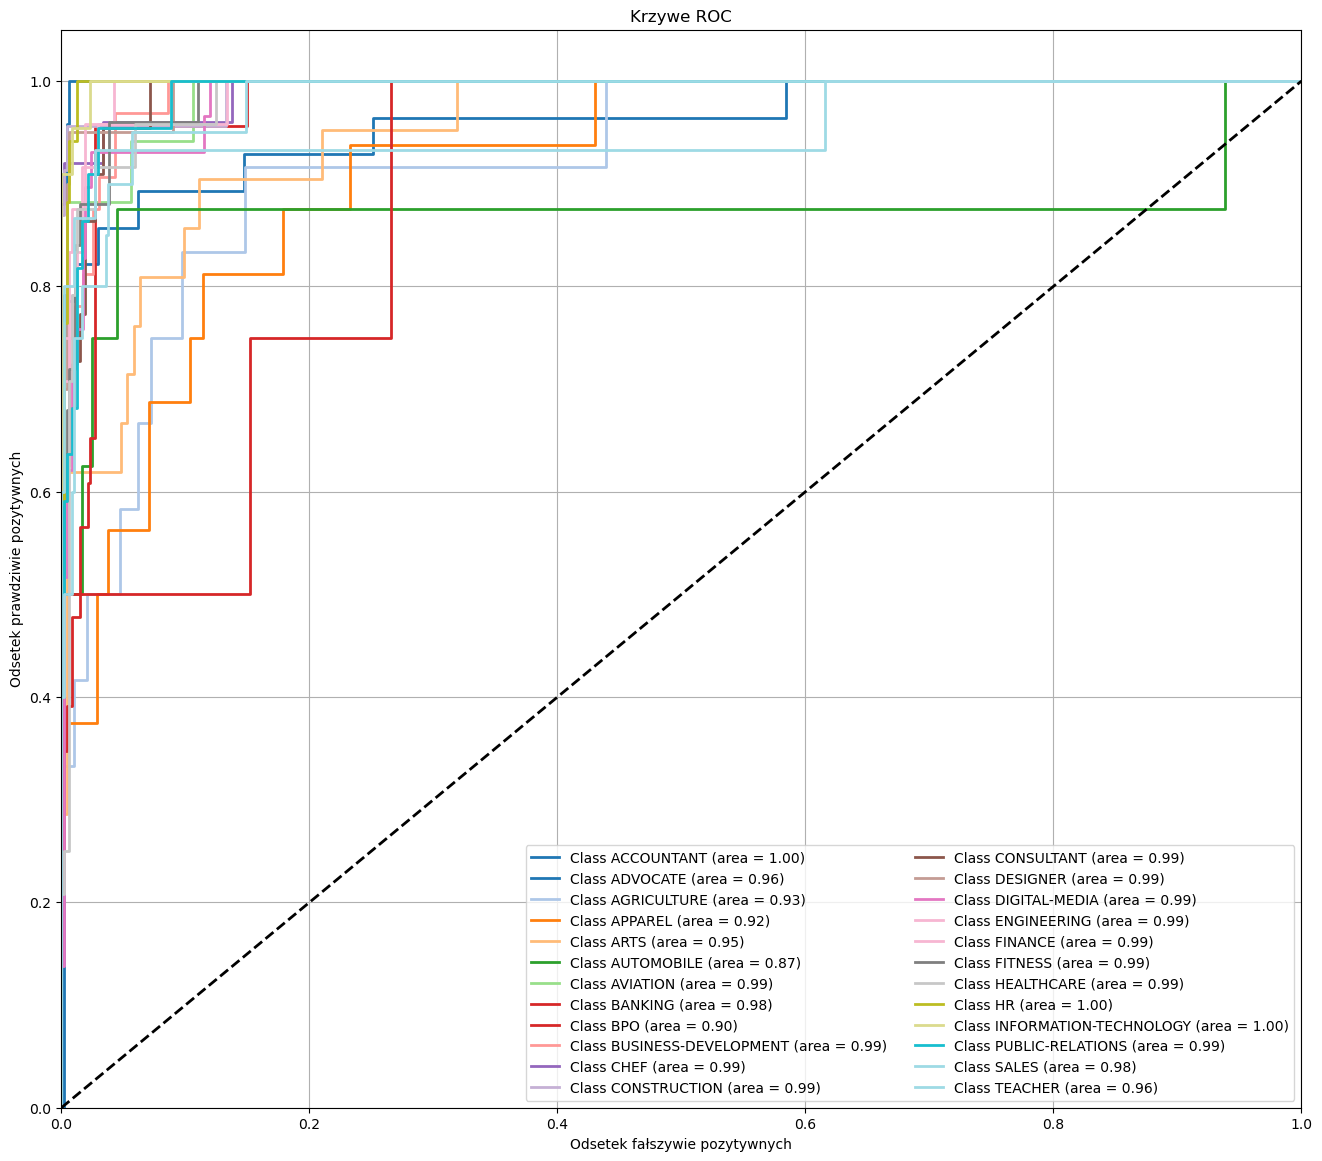

Gini Coefficient: 0.9439958766169507


In [140]:
n_classes = len(label_encoder.classes_)
colors = cm.get_cmap('tab20', n_classes)

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(16, 14))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2, label=f'Class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Krzywe ROC')

plt.legend(loc="lower right", bbox_to_anchor=(1, 0), ncol=2)

plt.grid(True)
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
gini = 2 * roc_auc - 1
print(f'Gini Coefficient: {gini}')